### This notebook takes 6 day of normalized (percentile 33, 66) MS data and create a bayesian network 
### Focus on Marginal probability for prediction

In [111]:
import pickle
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
import networkx as nx
import pylab as plt
from pgmpy.inference import VariableElimination
import pdb
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

In [2]:
## Load Sequences (Normalized using percentiles) (six days)

data_features = pd.read_csv('csv_files_MS/final_MS_df_variables.csv')
for i in range(len(data_features)):
    data_features.loc[i, 'Patient_ID'] = str(data_features.loc[i, 'Patient_ID'])
#Load the processed and normalized  dataset 
with open('MS_normalized_df_six_days.pkl', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    data.loc[i, 'Patient_ID'] = str(data.loc[i, 'Patient_ID'])

#Load the processed and normalized  dataset 
with open('MS_normalized_df.pkl', 'rb') as f:
    data_full = pickle.load(f)

for i in range(len(data)):
    data_full.loc[i, 'Patient_ID'] = str(data_full.loc[i, 'Patient_ID'])


In [3]:
data[data["Patient_ID"] == "1033"].tail(1)["EOD_PAW"]

929    Higher
Name: EOD_PAW, dtype: object

In [4]:
data_full[data_full["Patient_ID"] == "1005"]

,Patient_ID,Gender,Age,Daytime_Interval,Patient_Interval_Number,Pain_Score,Action_Pain,Fatigue_Score,Action_Fatigue,Last_Activitybout_State,Current_Activitybout_Action,EOD_PAW,Action_PAW
140,1005,Female,Between 30 to 60,Wake,1,Higher,Recorded,Normal,Recorded,Not Recorded,Normal,None,None
141,1005,Female,Between 30 to 60,Morning,2,Higher,Recorded,Lower,Recorded,Normal,Higher,None,None
142,1005,Female,Between 30 to 60,Afternoon,3,Higher,Recorded,Normal,Recorded,Higher,Lower,None,None
143,1005,Female,Between 30 to 60,Evening,4,Higher,Recorded,Normal,Recorded,Lower,Lower,None,Recorded
144,1005,Female,Between 30 to 60,Bed,5,Higher,Recorded,Normal,Recorded,Lower,Higher,Normal,None
145,1005,Female,Between 30 to 60,Wake,6,Normal,Recorded,Lower,Recorded,Higher,Higher,None,None
146,1005,Female,Between 30 to 60,Morning,7,Normal,Recorded,Lower,Recorded,Higher,Normal,None,None
147,1005,Female,Between 30 to 60,Afternoon,8,Lower,Recorded,Lower,Recorded,Normal,Lower,None,None
148,1005,Female,Between 30 to 60,Evening,9,Normal,Recorded,Lower,Recorded,Lower,Lower,None,Recorded
149,1005,Female,Between 30 to 60,Bed,10,Normal,Recorded,Normal,Recorded,Lower,Normal,Normal,None


In [5]:
data_features_new = data_features.drop(data_features[(data_features['Patient_Interval_Number'] <30) | (data_features['Patient_Interval_Number'] == 35)].index).reset_index(drop=True)
data_features_dummy = data_features.drop(data_features[(data_features['Patient_Interval_Number'] <31)].index).reset_index(drop=True)
data_features_new["Next_Pain"] = data_features_dummy["Pain_Score"]
data_features_new["Next_Fatigue"] = data_features_dummy["Fatigue_Score"]
data_features_new["Next_PAW"] = data_features_dummy["EOD_PAW"]
data_features_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_features_true = data_features_new.copy()
data_features_true.fillna(value="None", inplace = True)
data_features_new.drop(columns = ["Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)
############### Replace. None-> "None" ####
data_features_new.fillna(value="None", inplace = True)

In [6]:
data_features_new

,Gender,Age,Start_Day_Anna,Education,Living_Alone,Work,Use_Mobility_Aids,MS_Subtype,How_long,Start_Date,...,Action_fatigue,Action_Cognition,Action_Depression,Record_Next_PAW,Action_SRA,Action_UE,Action_LE,Next_Pain,Next_Fatigue,Next_PAW
0,Female,50 and Older,Mon,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-13,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
1,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
2,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,Low,Not Recorded
3,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,Low,Not Recorded
4,Female,50 and Older,Tue,College or Technical School,Yes,Unemployed,No,Relapsing Remitting,Less than 5 Years,2014-10-14,...,Recorded,Recorded,Recorded,Recorded,Recorded,Recorded,Recorded,Low,Low,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Female,Between 20 to 50,Wed,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-06,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded
531,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Low,High,Not Recorded
532,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Recorded,Recorded,Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Moderate,Moderate,Not Recorded
533,Female,Between 20 to 50,Thu,High School or Less,No,Unemployed,No,Relapsing Remitting,More than 9 Years,2016-04-07,...,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Not Recorded


In [7]:
# data_full_new = data_full[data_full['Patient_Interval_Number'] >31 and data_full['Patient_Interval_Number'] <35] 
data_full_new = data_full.drop(data_full[(data_full['Patient_Interval_Number'] <30) | (data_full['Patient_Interval_Number'] == 35)].index).reset_index(drop=True)
data_full_dummy = data_full.drop(data_full[(data_full['Patient_Interval_Number'] <31)].index).reset_index(drop=True)
data_full_new["Next_Pain"] = data_full_dummy["Pain_Score"]
data_full_new["Next_Fatigue"] = data_full_dummy["Fatigue_Score"]
data_full_new["Next_PAW"] = data_full_dummy["EOD_PAW"]
data_full_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_full_true = data_full_new.copy()
data_full_true.fillna(value="None", inplace = True)
data_full_new.drop(columns = ["Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)
############### Replace. None-> "None" ####
data_full_new.fillna(value="None", inplace = True)






In [8]:
data_full_new

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_Pain,Next_Fatigue,Next_PAW
0,Female,Between 30 to 60,Bed,Normal,Not Recorded,Higher,Not Recorded,Normal,Lower,None,Not Recorded,Not Recorded,None
1,Female,Between 30 to 60,Wake,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Lower,Lower,None,Not Recorded,Not Recorded,None
2,Female,Between 30 to 60,Morning,Not Recorded,Recorded,Not Recorded,Recorded,Lower,Lower,None,Higher,Normal,None
3,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Lower,None,Normal,Normal,None
4,Female,Between 30 to 60,Evening,Normal,Recorded,Normal,Recorded,Lower,Normal,Recorded,Normal,Normal,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,Female,Between 30 to 60,Bed,Not Recorded,Not Recorded,Not Recorded,Not Recorded,Higher,Higher,None,Not Recorded,Not Recorded,None
531,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Higher,Lower,None,Lower,Higher,None
532,Female,Between 30 to 60,Morning,Lower,Recorded,Higher,Recorded,Lower,Lower,None,Higher,Normal,None
533,Female,Between 30 to 60,Afternoon,Higher,Not Recorded,Normal,Not Recorded,Lower,Higher,None,Not Recorded,Not Recorded,None


In [9]:
print(data.shape)

(3210, 13)


In [10]:
data_new = pd.DataFrame()

In [11]:
data_new = data.drop(data[data['Patient_Interval_Number'] == 30].index).reset_index()
data_dummy = data.drop(data[data['Patient_Interval_Number'] == 1].index).reset_index()
    

In [12]:
data_new["Next_Pain"] = data_dummy["Pain_Score"]
data_new["Next_Fatigue"] = data_dummy["Fatigue_Score"]
data_new["Next_PAW"] = data_dummy["EOD_PAW"]
#data_new.drop(columns[""])

In [13]:
data_new.rename(columns={"Daytime_Interval": "Current_Daytime_Interval", "Pain_Score": "Current_Pain", "Action_Pain":"Record_Next_Pain", "Fatigue_Score":"Current_Fatigue", "Action_Fatigue":"Record_Next_Fatigue", "Last_Activitybout_State":"Last_Acbout", "Current_Activitybout_Action":"Current_Acbout", "Action_PAW":"Record_Next_PAW"}, inplace = True)
data_new.drop(columns = ["index", "Patient_ID", "Patient_Interval_Number", "EOD_PAW"], inplace = True)


In [14]:
data_new

,Gender,Age,Current_Daytime_Interval,Current_Pain,Record_Next_Pain,Current_Fatigue,Record_Next_Fatigue,Last_Acbout,Current_Acbout,Record_Next_PAW,Next_Pain,Next_Fatigue,Next_PAW
0,Female,Between 30 to 60,Wake,Higher,Recorded,Normal,Recorded,Not Recorded,Higher,None,Lower,Lower,None
1,Female,Between 30 to 60,Morning,Lower,Recorded,Lower,Recorded,Higher,Normal,None,Higher,Normal,None
2,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Normal,Higher,None,Higher,Higher,None
3,Female,Between 30 to 60,Evening,Higher,Recorded,Higher,Recorded,Higher,Lower,Recorded,Normal,Higher,Normal
4,Female,Between 30 to 60,Bed,Normal,Recorded,Higher,Recorded,Lower,Lower,None,Normal,Normal,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,Female,Between 30 to 60,Bed,Lower,Not Recorded,Not Recorded,Not Recorded,Higher,Normal,None,Not Recorded,Not Recorded,None
3099,Female,Between 30 to 60,Wake,Not Recorded,Recorded,Not Recorded,Recorded,Normal,Lower,None,Lower,Normal,None
3100,Female,Between 30 to 60,Morning,Lower,Recorded,Normal,Recorded,Lower,Lower,None,Higher,Normal,None
3101,Female,Between 30 to 60,Afternoon,Higher,Recorded,Normal,Recorded,Lower,Normal,None,Normal,Lower,None


In [15]:
############### Replace. None-> "None" ####
data_new.fillna(value="None", inplace = True)
#data_new.fillna(value= pd.np.nan, inplace = True)

In [16]:
data_new.to_csv("csv_files_MS/Bayesian_MS_data_six_days.csv", index = False)

In [17]:
len(data_new.dtypes)

13

In [18]:
data_new.dtypes

Gender                      object
Age                         object
Current_Daytime_Interval    object
Current_Pain                object
Record_Next_Pain            object
Current_Fatigue             object
Record_Next_Fatigue         object
Last_Acbout                 object
Current_Acbout              object
Record_Next_PAW             object
Next_Pain                   object
Next_Fatigue                object
Next_PAW                    object
dtype: object

### Lets start Bayesian

In [19]:
#create list of tuples for 13 node connections
list_of_tup = [("Gender", "Current_Pain"), ("Gender", "Next_Pain"), ("Gender", "Next_PAW"), ("Gender", "Next_Fatigue"), ("Gender", "Current_Fatigue"),
              ("Age", "Current_Pain"), ("Age", "Next_Pain"), ("Age", "Next_PAW"), ("Age", "Next_Fatigue"), ("Age", "Current_Fatigue"),
              ("Current_Daytime_Interval", "Current_Pain"), ("Current_Daytime_Interval", "Next_Pain"), ("Current_Daytime_Interval", "Next_PAW"), ("Current_Daytime_Interval", "Next_Fatigue"), ("Current_Daytime_Interval", "Current_Fatigue"),
              ("Last_Acbout", "Current_Fatigue"), 
              ("Current_Pain", "Next_Pain"), ("Current_Pain", "Current_Fatigue"),
              ("Current_Fatigue", "Next_Fatigue"),
              ("Current_Acbout", "Next_PAW"), ("Current_Acbout", "Next_Fatigue"), 
              ("Record_Next_Pain", "Next_Pain"), 
              ("Record_Next_Fatigue", "Next_Fatigue"), 
              ("Record_Next_PAW", "Next_PAW"), 
              ("Next_Pain", "Next_PAW"), ("Next_Pain", "Next_Fatigue"), 
              ("Next_Fatigue", "Next_PAW")]


# list_of_tup = [("Gender", "Current_Pain"), ("Gender", "Next_Pain"), ("Gender", "Next_PAW"), ("Gender", "Next_Fatigue"), ("Gender", "Current_Fatigue"),
#               ("Age", "Current_Pain"), ("Age", "Next_Pain"), ("Age", "Next_PAW"), ("Age", "Next_Fatigue"), ("Age", "Current_Fatigue"),
#               ("Current_Daytime_Interval", "Current_Pain"), ("Current_Daytime_Interval", "Next_Pain"), ("Current_Daytime_Interval", "Next_PAW"), ("Current_Daytime_Interval", "Next_Fatigue"), ("Current_Daytime_Interval", "Current_Fatigue"),
#               ("Last_Acbout", "Current_Fatigue"), 
#               ("Current_Pain", "Next_Pain"), ("Current_Pain", "Current_Fatigue"),
#               ("Current_Fatigue", "Next_Fatigue"),
#               ("Current_Acbout", "Next_PAW"), ("Current_Acbout", "Next_Fatigue"), 
#               ("Record_Next_Pain", "Next_Pain"), 
#               ("Record_Next_Fatigue", "Next_Fatigue"),
#               ("Next_Pain", "Next_PAW"), ("Next_Pain", "Next_Fatigue"), 
#               ("Next_Fatigue", "Next_PAW")]



In [20]:
model = BayesianModel(list_of_tup)

<IPython.core.display.Javascript object>


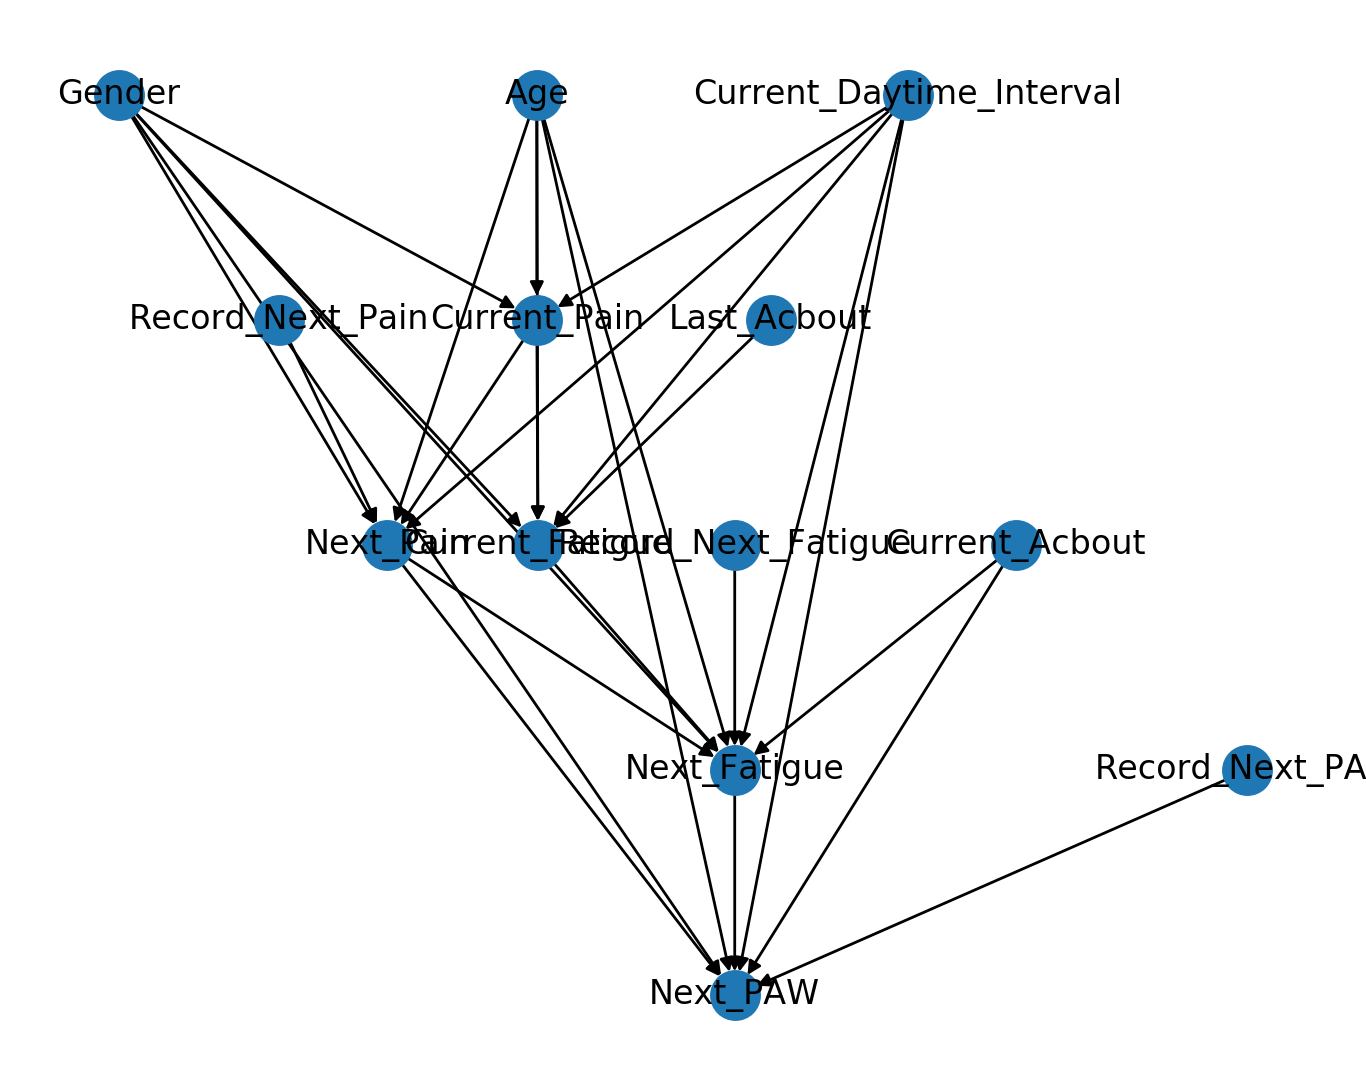

In [110]:
%matplotlib notebook
#Draw
# nx.draw(model, with_labels=True)
# plt.show()
pos = graphviz_layout(model, prog = 'dot')
nx.draw(model,with_labels=True, pos = pos)

In [22]:
#Fitting the model with data
# Learing CPDs using Maximum Likelihood Estimators
#model.fit(data_new[:3000], estimator=BayesianEstimator)
model.fit(data_new, estimator=BayesianEstimator)

In [23]:
model.nodes()

NodeView(('Gender', 'Current_Pain', 'Next_Pain', 'Next_PAW', 'Next_Fatigue', 'Current_Fatigue', 'Age', 'Current_Daytime_Interval', 'Last_Acbout', 'Current_Acbout', 'Record_Next_Pain', 'Record_Next_Fatigue', 'Record_Next_PAW'))

In [24]:
model.edges()

OutEdgeView([('Gender', 'Current_Pain'), ('Gender', 'Next_Pain'), ('Gender', 'Next_PAW'), ('Gender', 'Next_Fatigue'), ('Gender', 'Current_Fatigue'), ('Current_Pain', 'Next_Pain'), ('Current_Pain', 'Current_Fatigue'), ('Next_Pain', 'Next_PAW'), ('Next_Pain', 'Next_Fatigue'), ('Next_Fatigue', 'Next_PAW'), ('Current_Fatigue', 'Next_Fatigue'), ('Age', 'Current_Pain'), ('Age', 'Next_Pain'), ('Age', 'Next_PAW'), ('Age', 'Next_Fatigue'), ('Age', 'Current_Fatigue'), ('Current_Daytime_Interval', 'Current_Pain'), ('Current_Daytime_Interval', 'Next_Pain'), ('Current_Daytime_Interval', 'Next_PAW'), ('Current_Daytime_Interval', 'Next_Fatigue'), ('Current_Daytime_Interval', 'Current_Fatigue'), ('Last_Acbout', 'Current_Fatigue'), ('Current_Acbout', 'Next_PAW'), ('Current_Acbout', 'Next_Fatigue'), ('Record_Next_Pain', 'Next_Pain'), ('Record_Next_Fatigue', 'Next_Fatigue'), ('Record_Next_PAW', 'Next_PAW')])

### Validation (Using marginal probability)

In [25]:
infer = VariableElimination(model)

In [26]:
def marginal_pain(query_pain):
    outcome_dict = {}
    pain_vars_list = query_pain['Next_Pain'].state_names['Next_Pain']
    pain_value_list = query_pain['Next_Pain'].values
    for i in range(len(pain_vars_list)):
        outcome_dict["Next_Pain_"+pain_vars_list[i]] = pain_value_list[i]
    
    return outcome_dict
def marginal_fatigue(query_fatigue):
    outcome_dict = {}
    fatigue_vars_list = query_fatigue['Next_Fatigue'].state_names['Next_Fatigue']
    fatigue_value_list = query_fatigue['Next_Fatigue'].values
    for i in range(len(fatigue_vars_list)):
        outcome_dict["Next_Fatigue_"+fatigue_vars_list[i]] = fatigue_value_list[i]
    return outcome_dict
    

In [27]:
predict_data = data_full_new.copy()
prediction_marginal_df = pd.DataFrame() #columns = ["Next_Pain_Pred", "Next_Fatigue_Pred", "Next_PAW_Pred"]
# col_list = ['Next_PAW_Higher', 'Next_PAW_Lower', 'Next_PAW_None', 'Next_PAW_Normal', 'Next_PAW_Not Recorded', 'Next_Pain_Higher', 'Next_Pain_Lower',
#              'Next_Pain_Normal', 'Next_Pain_Not Recorded', 'Next_Fatigue_Higher', 'Next_Fatigue_Lower', 'Next_Fatigue_Normal', 'Next_Fatigue_Not Recorded']
col_list_pain = ['Next_Pain_Pred', 'Next_Pain_Higher', 'Next_Pain_Lower', 'Next_Pain_Normal', 'Next_Pain_Not_Recorded']
col_list_fatigue = ['Next_Fatigue_Pred', 'Next_Fatigue_Higher', 'Next_Fatigue_Lower', 'Next_Fatigue_Normal', 'Next_Fatigue_Not_Recorded']
prediction_df_pain = pd.DataFrame(columns = col_list_pain) #marginal probability df
prediction_df_fatigue = pd.DataFrame(columns = col_list_fatigue)
index = 0
#predict_data.drop(['Next_Pain', 'Next_Fatigue', 'Next_PAW'], axis=1, inplace=True)
for i in range(len(predict_data)):
    print(i)
    evidence_dict = {}
    evidence_dict = predict_data[i:i+1].to_dict('index')[i]
    del evidence_dict["Next_Pain"]
    del evidence_dict["Next_Fatigue"]

    #predic_data = predict_data[i:i+1]
    #print(evidence_dict)
    if(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded"):
        query_pain = infer.query(['Next_Pain'], evidence = evidence_dict, joint = False, show_progress = False)
        map_query_pain = infer.map_query(['Next_Pain'], evidence = evidence_dict, show_progress = False)
        query_fatigue = infer.query(['Next_Fatigue'], evidence = evidence_dict, joint = False, show_progress = False)
        map_query_fatigue = infer.map_query(['Next_Fatigue'], evidence = evidence_dict, show_progress = False)
        
        outcome_dict_pain = marginal_pain(query_pain)
        outcome_dict_fatigue = marginal_fatigue(query_fatigue)
        
        prediction_df_pain.loc[i, "Next_Pain_Pred"] = map_query_pain["Next_Pain"]
        prediction_df_pain.loc[i, "Next_Pain_Higher"] = outcome_dict_pain["Next_Pain_Higher"]
        prediction_df_pain.loc[i, "Next_Pain_Lower"] = outcome_dict_pain["Next_Pain_Lower"]
        prediction_df_pain.loc[i, "Next_Pain_Normal"] = outcome_dict_pain["Next_Pain_Normal"]
        prediction_df_pain.loc[i, "Next_Pain_Not_Recorded"] = outcome_dict_pain["Next_Pain_Not Recorded"]
        
        prediction_df_fatigue.loc[i, "Next_Fatigue_Pred"] = map_query_fatigue["Next_Fatigue"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Higher"] = outcome_dict_fatigue["Next_Fatigue_Higher"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Lower"] = outcome_dict_fatigue["Next_Fatigue_Lower"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Normal"] = outcome_dict_fatigue["Next_Fatigue_Normal"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Not_Recorded"] = outcome_dict_fatigue["Next_Fatigue_Not Recorded"]
    elif(evidence_dict["Record_Next_Pain"] == "Not Recorded" and evidence_dict["Record_Next_Fatigue"]!= "Not Recorded"):
        query_fatigue = infer.query(['Next_Fatigue'], evidence = evidence_dict, joint = False, show_progress = False)
        map_query_fatigue = infer.map_query(['Next_Fatigue'], evidence = evidence_dict, show_progress = False)
        
        outcome_dict_fatigue = marginal_fatigue(query_fatigue)
        
        prediction_df_pain.loc[i, "Next_Pain_Pred"] = "Not Recorded"
        prediction_df_pain.loc[i, "Next_Pain_Higher"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Lower"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Normal"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Not_Recorded"] = 1
        
        prediction_df_fatigue.loc[i, "Next_Fatigue_Pred"] = map_query_fatigue["Next_Fatigue"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Higher"] = outcome_dict_fatigue["Next_Fatigue_Higher"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Lower"] = outcome_dict_fatigue["Next_Fatigue_Lower"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Normal"] = outcome_dict_fatigue["Next_Fatigue_Normal"]
        prediction_df_fatigue.loc[i, "Next_Fatigue_Not_Recorded"] = outcome_dict_fatigue["Next_Fatigue_Not Recorded"]
        
        
        
    elif(evidence_dict["Record_Next_Pain"] != "Not Recorded" and evidence_dict["Record_Next_Fatigue"]== "Not Recorded"):
        query_pain = infer.query(['Next_Pain'], evidence = evidence_dict, joint = False, show_progress = False)
        map_query_pain = infer.map_query(['Next_Pain'], evidence = evidence_dict, show_progress = False)
        
        outcome_dict_pain = marginal_pain(query_pain)
        
        prediction_df_pain.loc[i, "Next_Pain_Pred"] = map_query_pain["Next_Pain"]
        prediction_df_pain.loc[i, "Next_Pain_Higher"] = outcome_dict_pain["Next_Pain_Higher"]
        prediction_df_pain.loc[i, "Next_Pain_Lower"] = outcome_dict_pain["Next_Pain_Lower"]
        prediction_df_pain.loc[i, "Next_Pain_Normal"] = outcome_dict_pain["Next_Pain_Normal"]
        prediction_df_pain.loc[i, "Next_Pain_Not_Recorded"] = outcome_dict_pain["Next_Pain_Not Recorded"]
        
        prediction_df_fatigue.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
        prediction_df_fatigue.loc[i, "Next_Fatigue_Higher"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Lower"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Normal"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Not_Recorded"] = 1
    
    else:
        prediction_df_pain.loc[i, "Next_Pain_Pred"] = "Not Recorded"
        prediction_df_pain.loc[i, "Next_Pain_Higher"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Lower"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Normal"] = 0
        prediction_df_pain.loc[i, "Next_Pain_Not_Recorded"] = 1
        
        prediction_df_fatigue.loc[i, "Next_Fatigue_Pred"] = "Not Recorded"
        prediction_df_fatigue.loc[i, "Next_Fatigue_Higher"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Lower"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Normal"] = 0
        prediction_df_fatigue.loc[i, "Next_Fatigue_Not_Recorded"] = 1
        
#     if(i == 5):
#         break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [38]:
prediction_df_pain["Next_Pain_True"] = predict_data["Next_Pain"]
#prediction_df_pain["Next_PAW_True"] = predict_data["Next_PAW"]
prediction_df_pain["Patient_ID"] = data_full_true["Patient_ID"]

In [52]:
#drop true NR values 
indexNames = prediction_df_pain[ prediction_df_pain['Next_Pain_True'] == "Not Recorded" ].index
# Delete these row indexes from dataFrame
prediction_df_pain.drop(indexNames , inplace=True)
prediction_df_pain = prediction_df_pain.reset_index(drop = True)

In [81]:
#Marginal prediction for pain
prediction_df_pain

,Next_Pain_Pred,Next_Pain_Higher,Next_Pain_Lower,Next_Pain_Normal,Next_Pain_Not_Recorded,Next_Pain_True,Patient_ID
0,Normal,0.106818,0.200093,0.69295,0.000138758,Higher,1001
1,Higher,0.540898,0.0328543,0.426214,3.41437e-05,Normal,1001
2,Normal,0.241157,0.09368,0.665142,2.02075e-05,Normal,1001
3,Normal,0.130449,0.18117,0.688366,1.5095e-05,Normal,1002
4,Normal,0.118341,0.118353,0.763294,1.23264e-05,Normal,1002
...,...,...,...,...,...,...,...
429,Normal,0.184999,0.100004,0.714986,1.04158e-05,Normal,1109
430,Normal,0.204193,0.089013,0.706783,1.09065e-05,Higher,1109
431,Normal,0.402064,0.0567371,0.541167,3.2224e-05,Normal,1109
432,Normal,0.212164,0.212153,0.57562,6.3103e-05,Lower,1110


In [56]:
prediction_df_fatigue["Next_Fatigue_True"] = predict_data["Next_Fatigue"]
prediction_df_fatigue["Patient_ID"] = data_full_true["Patient_ID"]

In [65]:
#drop true NR values 
indexNames = prediction_df_fatigue[ prediction_df_fatigue['Next_Fatigue_True'] == "Not Recorded" ].index
# Delete these row indexes from dataFrame
prediction_df_fatigue.drop(indexNames , inplace=True)
indexNames2 = prediction_df_fatigue[ prediction_df_fatigue['Next_Fatigue_Pred'] == "Not Recorded" ].index
prediction_df_fatigue.drop(indexNames2 , inplace=True)
prediction_df_fatigue = prediction_df_fatigue.reset_index(drop = True)

In [68]:
prediction_df_fatigue

,Next_Fatigue_Pred,Next_Fatigue_Higher,Next_Fatigue_Lower,Next_Fatigue_Normal,Next_Fatigue_Not_Recorded,Next_Fatigue_True,Patient_ID
0,Lower,0.250016,0.449868,0.250026,0.0500897,Normal,1001
1,Normal,0.347946,0.0258435,0.626185,2.58273e-05,Normal,1001
2,Higher,0.619039,0.0295845,0.35136,1.68082e-05,Normal,1001
3,Normal,0.110907,0.31566,0.573418,1.43803e-05,Normal,1002
4,Normal,0.102286,0.373196,0.524506,1.23538e-05,Normal,1002
...,...,...,...,...,...,...,...
426,Normal,0.149698,0.0486119,0.801679,1.0878e-05,Normal,1109
427,Normal,0.247828,0.163078,0.589085,9.16015e-06,Lower,1109
428,Higher,0.577217,0.190696,0.232045,4.095e-05,Higher,1109
429,Normal,0.327264,0.141471,0.53121,5.49874e-05,Higher,1110


In [108]:
### Save marginal predictions
prediction_df_pain.to_csv("csv_files_MS/prediction_marginal_df_pain.csv")
prediction_df_fatigue.to_csv("csv_files_MS/prediction_marginal_df_fatigue.csv")

### Generate Confusion Matrix

In [102]:
def analysis_person(person, pred_df_pain, pred_df_fatigue):
    data_pain = pred_df_pain[pred_df_pain.Patient_ID == person]
    data_fatigue = pred_df_fatigue[pred_df_fatigue.Patient_ID == person]
    #data_paw = pred_df_dummy[pred_df.Patient_ID == person]
    # Pain
    title = person+"-Pain_marginal"
    label_list = ["Normal", "Lower", "Higher"]
    cm = confusion_matrix(data_pain["Next_Pain_True"], data_pain["Next_Pain_Pred"], labels = label_list)
    conf_mat(cm, title, label_list, sns.color_palette("Blues"))
    
    # Fatigue
    title = person+"-Fatigue_marginal"
    label_list = ["Normal", "Lower", "Higher"]
    cm = confusion_matrix(data_fatigue["Next_Fatigue_True"], data_fatigue["Next_Fatigue_Pred"], labels = label_list)
    conf_mat(cm, title, label_list, sns.light_palette("navy", reverse=True))
    
#     # PAW
#     title = person+"-PAW"
#     label_list = ["Normal", "Lower", "Higher", "Not Recorded"]
#     cm = confusion_matrix(data_paw["Next_PAW_True"], data_paw["Next_PAW_Pred"], labels = label_list)
#     conf_mat(cm, title, label_list, sns.cubehelix_palette(8))
    return None
def conf_mat(cm, title, label_list, color):
    plt.ioff()
    fig, ax = plt.subplots()
    ax= plt.subplot()
    sns.heatmap(cm.T, annot=True, ax = ax, cmap = color); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('True labels');ax.set_ylabel('Pred labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(label_list); ax.yaxis.set_ticklabels(label_list);
    plt.savefig("saved_figures/marginal_proba_confu_matrix/"+title+'.png')
    #plt.show()

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [104]:
Person_list = []   #total 20 patients , missing patient_id: 1017, 1021; last patient id:1008
for i in range(1001, 1111, 1): #original 1111
    if(i== 1017 or i == 1021 or i == 1051):
        pass
    else:
        Person_list.append(str(i))

In [105]:
#Person_list = ["1005"]

In [106]:
%matplotlib notebook
for person in Person_list:
    print(person)
    try:
        analysis_person(person, prediction_df_pain, prediction_df_fatigue)
    except:
        print("level error")
        continue
print("Finished")

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1018
1019
1020
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
level error
1042
1043
1044
level error
1045
1046
1047
1048
1049
1050
1052
1053
1054
1055
1056
1057
level error
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
level error
1079
1080
level error
1081
1082
1083
1084
1085
1086
1087
1088
1089
level error
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
Finished


### precision recall overall

In [107]:
########## Calculate precision, recall, accuracy
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, accuracy_score

In [90]:
## Precision
#Excluding NR
#### For joint proba distribution 
avg_type = 'macro'

Precision_Pain = precision_score(prediction_df_pain["Next_Pain_True"], prediction_df_pain["Next_Pain_Pred"], average = avg_type)
print("Precision_Pain_marginal", Precision_Pain)
Precision_Fatigue = precision_score(prediction_df_fatigue["Next_Fatigue_True"], prediction_df_fatigue["Next_Fatigue_Pred"], average = avg_type)
print("Precision_Fatigue_marginal", Precision_Fatigue)

Precision_Pain_marginal 0.5668596999210318
Precision_Fatigue_marginal 0.4425311687511589


In [91]:
## recall
#Excluding NR
#### For joint proba distribution 
avg_type = 'macro'

recall_Pain = recall_score(prediction_df_pain["Next_Pain_True"], prediction_df_pain["Next_Pain_Pred"], average = avg_type)
print("recall_Pain_marginal", recall_Pain)
recall_Fatigue = recall_score(prediction_df_fatigue["Next_Fatigue_True"], prediction_df_fatigue["Next_Fatigue_Pred"], average = avg_type)
print("recall_Fatigue_marginal", recall_Fatigue)

recall_Pain_marginal 0.40107021519660924
recall_Fatigue_marginal 0.4144474111910843


In [260]:
# del evidence_dict["Next_Fatigue"]
# del evidence_dict["Next_PAW"]
# del evidence_dict["Next_Pain"]

In [261]:
# variable = "Fatigue"

In [262]:
# q_joint = infer.query(['Next_'+variable], evidence = evidence_dict, joint = True)
# print(q_joint)

In [263]:
#q_marginal = infer.query(['Next_'+variable], evidence = evidence_dict, joint = False)


In [264]:
#print(q_marginal['Next_Fatigue'])

In [265]:
#print(q_marginal['Next_Fatigue'].values[0])

In [266]:
#print(q_marginal['Next_Fatigue'].assignment([0])[0])

In [267]:
# list_a = q_marginal['Next_Fatigue'].state_names['Next_Fatigue']
# print(list_a)

In [268]:
#print(q_marginal['Next_Fatigue'].values)

In [269]:
#max_marg = infer.max_marginal(['Next_'+variable], evidence = evidence_dict)

In [270]:
#print(max_marg)

In [271]:
#map_quer = infer.map_query(['Next_'+variable], evidence = evidence_dict)


In [272]:
#print(map_quer['Next_Fatigue'])